## New York City Taxi Trip Duration 
홈페이지 = "https://www.kaggle.com/gguddu/new-york-taxi-duration"

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import skew, norm
from sklearn.cluster import KMeans

In [46]:
train = pd.read_csv('../kaggle/nyc_taxi/train.csv')
test = pd.read_csv('../kaggle/nyc_taxi/test.csv')
sub = pd.read_csv('../kaggle/nyc_taxi/sample_submission.csv')

In [3]:
# target 인 trip duration과 target을 계산 할 수 있는 dropoff time 이 없다. 
print(train.shape)
print(test.shape)

(1458644, 11)
(625134, 9)


In [4]:
train.info

<bound method DataFrame.info of                 id  vendor_id      pickup_datetime     dropoff_datetime  \
0        id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1        id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2        id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3        id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4        id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   
...            ...        ...                  ...                  ...   
1458639  id2376096          2  2016-04-08 13:31:04  2016-04-08 13:44:02   
1458640  id1049543          1  2016-01-10 07:35:15  2016-01-10 07:46:10   
1458641  id2304944          2  2016-04-22 06:57:41  2016-04-22 07:10:25   
1458642  id2714485          1  2016-01-05 15:56:26  2016-01-05 16:02:39   
1458643  id1209952          1  2016-04-05 14:44:25  2016-04-05 14:47:43   

         passenger_count  pickup_longitude  pickup_latitude  \
0   

* 날짜 데이터 분리(픽업 데이터 타임,연,월,일,일자,시간,요일 컬럼)

In [70]:
def datetime_split(data) :
    data['pickup_datetime'] = data.pickup_datetime.apply(pd.to_datetime)
    data['year'] = data.pickup_datetime.apply(lambda x : x.year)
    data['month'] = data.pickup_datetime.apply(lambda x : x.month)
    data['day'] = data.pickup_datetime.apply(lambda x : x.day)
    data['hour'] = data.pickup_datetime.apply(lambda x  : x.hour)
    data['dayofweek'] = data.pickup_datetime.apply(lambda x : x.dayofweek)
    
datetime_split(train)
datetime_split(test)

In [71]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,ln_target,haversine,manhattan,ln_haversine,ln_manhattan,year,month,day,hour,dayofweek
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,6.122493,1.498521,1.735433,0.915699,1.006290,2016,3,14,17,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.498282,1.805507,2.430506,1.031584,1.232708,2016,6,12,0,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,7.661527,6.385098,8.203575,1.999464,2.219592,2016,1,19,11,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,6.063785,1.485498,1.661331,0.910473,0.978826,2016,4,6,19,2
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,6.077642,1.188588,1.199457,0.783257,0.788210,2016,3,26,13,5


In [7]:
train.drop('year', axis = 1,  inplace = True)
test.drop('year', axis = 1, inplace = True)

* pickup_datetime 을 살펴보면 모두 2016년 데이터 이므로 year는 삭제 하였다. 
* 시간별로 택시 이용시간이 다를것으로 예상이 되고 또한 공휴일과 아닌날의 차이가 있을것이라 생각이든다. 
* 요일별로 나눠보기도 하고 주말 or not 의 형태로 나눠봐야될거 같다. 월별로 택시 이용시간이 다를수 있다.
* passenger_count를 살펴 보았을때 승객의 수가 택시의 승차 시간에 영향을 줄지 궁금하다
* 승차 위치와 하차 위치가 데이터로 존재하니까 승차위치와 하차 위치로 움직인 거리를 도출 하면 상관계수가 꽤나 높을 것 같다.

## 1.2 Feature engineering

### 승차 위치와 하차 위치를 통해 움직인 거리를 구한다.

* 거리의 종류는 여러가지다. 여기서는 택시가 움직인 거리가 필요 하므로 유클리디안 거리와 맨해튼 거리를 구해보려 한다.
* 유클리디안 거리란 두 점의 공간 차이의 제곱합을 말하고 맨해튼 거리는 두 점의 공간 차이의 절대값의 합을 말한다.
* 맨해튼 거리는 택시거리라고도 불리기에 이번 택시 이용시간 예측에 가장 적합한 변수라 생각이 든다.

In [58]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

train['haversine'] = haversine_array(train['pickup_latitude'], 
                                     train['pickup_longitude'],
                                     train['dropoff_latitude'],
                                     train['dropoff_longitude'])

train['manhattan'] = dummy_manhattan_distance(train['pickup_latitude'], 
                                     train['pickup_longitude'],
                                     train['dropoff_latitude'],
                                     train['dropoff_longitude'])
test['haversine'] = haversine_array(test['pickup_latitude'], 
                                     test['pickup_longitude'],
                                     test['dropoff_latitude'],
                                     test['dropoff_longitude'])

test['manhattan'] = dummy_manhattan_distance(test['pickup_latitude'], 
                                     test['pickup_longitude'],
                                     test['dropoff_latitude'],
                                     test['dropoff_longitude'])

### 승하차 지역 

* new york의 행정구역은 총 200개다.
* new york도 서울처럼 구별로 유동인구의 분포가 다를 것이라는 가정하에 분석을 진행해보았다.
* 이 데이터로는 승하차의 위도 경도정보만 알 수 있고 지역의 이름은 알 수 없다.
* 따라서 비지도 학습인 kmeans를 이용해 지역 변수를 얻어 내고자 한다.
* 판단에 오류가 생길 수도 있으나 대략적인 분석을 위해 이와 같은 분석기법을 이용하였다.

In [10]:
xlim = [-74.03, -73.77] 
ylim = [40.63, 40.85]

(40.63, 40.85)

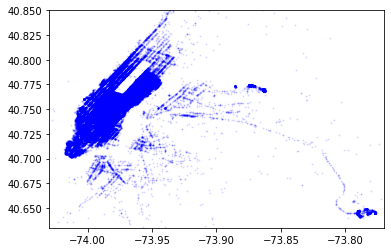

In [12]:
plt.scatter(train['pickup_longitude'].values[:100000], train['pickup_latitude'].values[:100000],
              color='blue', s=1, label='train', alpha=0.1)
plt.xlim(xlim)
plt.ylim(ylim)

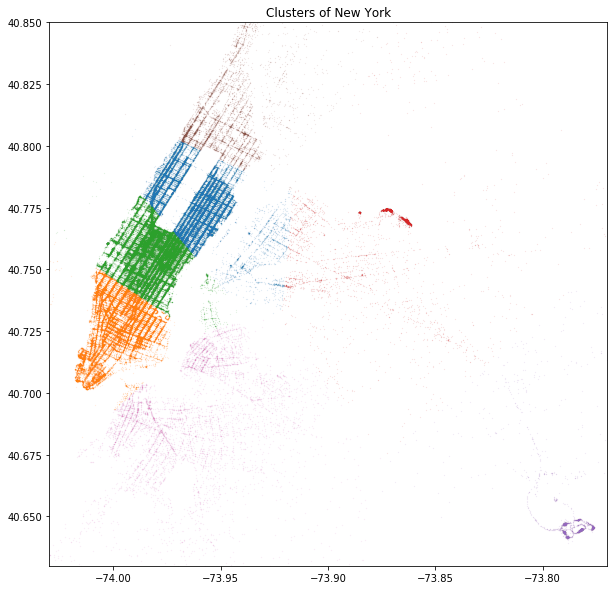

In [13]:
loc_df = pd.DataFrame()
longitude = list(train.pickup_longitude) + list(train.dropoff_longitude)
latitude = list(train.pickup_latitude) + list(train.dropoff_latitude)
loc_df['longitude'] = longitude
loc_df['latitude'] = latitude


kmeans = KMeans(n_clusters=12, random_state=2, n_init = 20).fit(loc_df)

loc_df['label'] = kmeans.labels_

loc_df = loc_df.sample(200000)
plt.figure(figsize = (10,10))
for label in loc_df.label.unique():
    plt.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 0.3, markersize = 0.3)

plt.xlim(xlim)
plt.ylim(ylim)
plt.title('Clusters of New York')
plt.show()

### target 분포 확인

Text(0.5, 0, 'Trip_duration')

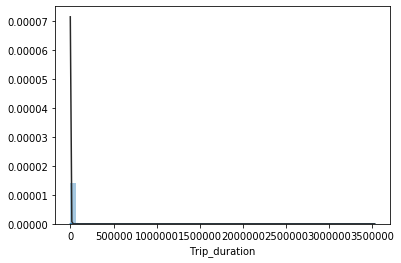

In [47]:
target = train['trip_duration']

sns.distplot(target, fit = norm)

plt.xlabel('Trip_duration')

* 분포의 모양이 이상하다. 
* 이상치로 인해 이런 모양을 띄는거 같으므로 boxplot을 그려본다.

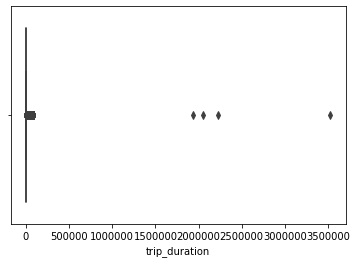

In [48]:
sns.boxplot(target)

+ 4개의 점이 이상하게 많이 동떨어져 있다.
* 4개만 따로 확인해봐야 될거 같다.

In [49]:
train[train['trip_duration'] > 1500000].head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,1939736
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,2049578
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,2227612
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,3526282


* 승차 시간이랑 하차시간의 날짜가 다르다. 
* 첫번째 행을 보면 22일동안 택시를 탔다고 나온다. 
* 이러한 이상치는 아마 택시 미터기를 끄자 않았거나 혹은 미터기의 고장으로 인해 잘못된 데이터일 가능성이 높다. 
* 그러므로 이 행들은 삭제를 하겠다.

In [41]:
train.drop(train[train['trip_duration'] > 150000].index, axis = 0, inplace = True)

### 이상치 제거 후 종속변수 분포 확인

Text(0.5, 0, 'Trip_duration')

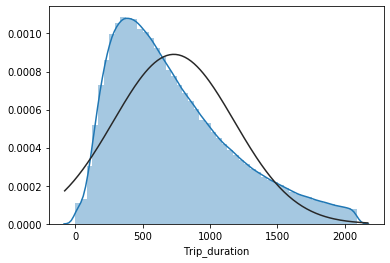

In [42]:
sns.distplot(train['trip_duration'], fit = norm)

plt.xlabel('Trip_duration')

In [50]:
train[train['trip_duration'] >= 20000].head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
531,id3307903,2,2016-02-20 04:03:06,2016-02-21 03:33:00,3,-74.008102,40.741489,-74.009956,40.714611,N,84594
1134,id1091477,2,2016-05-07 18:36:22,2016-05-08 18:32:11,1,-73.990242,40.750919,-73.976280,40.750889,N,86149
1865,id3431345,2,2016-06-07 12:58:48,2016-06-08 12:58:00,6,-73.954956,40.777649,-73.981033,40.743713,N,86352
3442,id1487069,2,2016-02-13 00:21:49,2016-02-14 00:19:05,1,-73.968590,40.799217,-73.979584,40.784714,N,86236
4172,id3674870,2,2016-03-18 11:54:20,2016-03-19 11:34:17,1,-73.989090,40.736992,-73.972336,40.751511,N,85197


* 여전히 승차시간이 24시간이나 되는 데이터들이 존재 한다.
* 이는 데이터가 잘못됐다고 생각이 들어 이상치를 제거해주도록 하겠다.

In [21]:
Q1 = np.percentile(train['trip_duration'], 25) 
Q3 = np.percentile(train['trip_duration'], 75)
IQR = Q3 - Q1 
outlier_step = 1.5 * IQR 
outlier_list_idx = train[train['trip_duration'] > Q3 + outlier_step].index

train.drop(outlier_list_idx, axis = 0, inplace = True)

Text(0.5, 1.0, 'skewness of target 0.861')

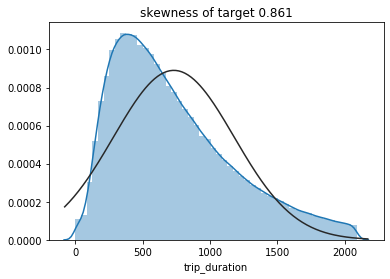

In [23]:
sns.distplot(train['trip_duration'], fit = norm)

plt.title('skewness of target {0:.3f}'.format(skew(train['trip_duration'])))

* boxplot에서 보이는 이상치들을 제거 했다.
* 값이 과하게 큰 값을 가지는 데이터만이 이상치라고 생각을 했다.
* 3/4 분위수와 1/4분위수의 차이를 iqr(Inter - Quatitle - range)이라하는데 이 iqr의 1.5배 만큼 떨어져있는 데이터를 이상치로 여길수 있다.
* 왼쪽으로 좀 치우쳐진 모습을 보이는 로그정규분포의 모습을 보이는거 같아 로그를 취해봤다.

Text(0.5, 1.0, 'skewness of target -0.290')

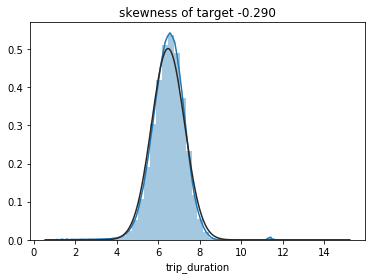

In [52]:
sns.distplot(np.log1p(train['trip_duration']), fit = norm)

plt.xlabel('trip_duration')
plt.title('skewness of target {0:.3f}'.format(skew(np.log1p(train['trip_duration']))))

* 조금 더 정규분포에 근사한 모습을 보인다. 따라서 target에 log를 취해주었다.

In [54]:
ln_target = np.log1p(train['trip_duration'])
train['ln_target'] = ln_target

## 설명 변수와 종속변수 간의 관계

### 거리와 target의 관계 파악

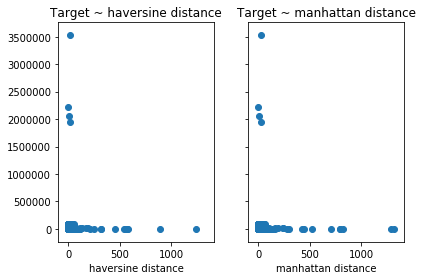

In [59]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)

axes[0].scatter(x = train['haversine'],
                y = train['trip_duration'])
axes[0].set_title('Target ~ haversine distance')
axes[0].set_xlabel('haversine distance')

axes[1].scatter(x = train['manhattan'],
                y = train['trip_duration'], )
axes[1].set_title('Target ~ manhattan distance')
axes[1].set_xlabel('manhattan distance')

plt.tight_layout()
plt.show()

* 거리의 기준이 km 인데 500km 를 넘게 이동한 데이터도 확인 할 수 있다.
* 아마 잘못 기록된것이 아닐까 생각이 든다. 하지만 testset에서도 이러한 이상치로 예상이 되는 데이터가 존재하는지 확인해봐야된다.

Text(0.5, 1.0, 'Boxplot of haversine')

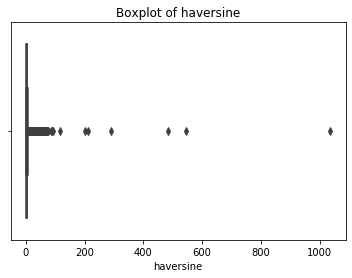

In [60]:
sns.boxplot(test['haversine'])

plt.xlabel('haversine')
plt.title('Boxplot of haversine')

* 역시나 test set에도 이상치로 여겨지는 데이터들이 존재한다. 
* 이럴경우 이 데이터들을 제외하고 예측 할 수 없으므로 이상치의 힘을 약화 시킬 무기가 필요하다.

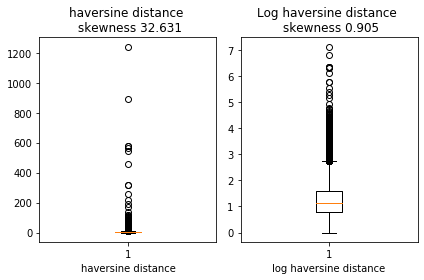

In [61]:
fig, axes = plt.subplots(1, 2, sharex=False)

axes[0].boxplot(train['haversine'])
axes[0].set_title('haversine distance \n skewness {:.3f}'.format(skew(train['haversine'])))
axes[0].set_xlabel('haversine distance')

axes[1].boxplot(np.log1p(train['haversine']))
axes[1].set_title('Log haversine distance \n skewness {:.3f}'.format(skew(np.log1p(train['haversine']))))
axes[1].set_xlabel('log haversine distance')


plt.tight_layout()
plt.show()

* Log를 취했을 때 이상치는 줄어들었다고 말할 수 는 없지만 그래도 box의 모양이 뚜렷해 졌다.
* 분포의 왜도(skewness) 또한 약 32에서 약 0.905 으로 줄어 들었다. 
* 왜도 값이 0이라는 것은 해당 분포가 완벽한 좌우 대칭의 형태를 보인다는 뜻이다.
* 왜도가 0에 가까울 수록 ols 추정법에서 세우는 가정 중 하나인 "모든 변수의 분포는 정규분포를 따른다."를 만족 할수 있다.

In [63]:
train['ln_haversine'] = np.log1p(train['haversine'])
train['ln_manhattan'] = np.log1p(train['manhattan'])
test['ln_haversine'] = np.log1p(test['haversine'])
test['ln_manhattan'] = np.log1p(test['manhattan'])

train[['haversine', 'manhattan','ln_haversine','ln_manhattan','trip_duration','ln_target']].corr()

,haversine,manhattan,ln_haversine,ln_manhattan,trip_duration,ln_target
haversine,1.000000,0.993509,0.844501,0.834519,0.094777,0.573595
manhattan,0.993509,1.000000,0.837164,0.834965,0.094225,0.564337
ln_haversine,0.844501,0.837164,1.000000,0.994539,0.102519,0.749882
ln_manhattan,0.834519,0.834965,0.994539,1.000000,0.101050,0.744762
trip_duration,0.094777,0.094225,0.102519,0.101050,1.000000,0.253521
ln_target,0.573595,0.564337,0.749882,0.744762,0.253521,1.000000


* 거리에 log를 취했을 때 종속변수와의 상관계수가 더 큰 것을 확인했다.
* 다만 종속변수에 log를 취하면 취하기전보다 더 낮은 상관계수를 가잔다.
* 이는 두 변수다 log를 취했을 때 산점도를 보면 비선형관계에 더 가까워 보이기 떄문이 아닐까 싶다.

## 시간대 , 요일별 target boxplot

Text(0.5, 1.0, 'Log trip duration ~ Hour')

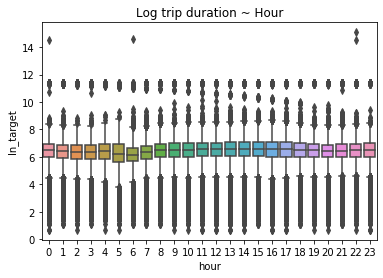

In [75]:
sns.boxplot(x = train['hour'],
            y = train['ln_target'])


plt.title('Log trip duration ~ Hour')

Text(0.5, 1.0, 'Log Target ~ Dayofweek')

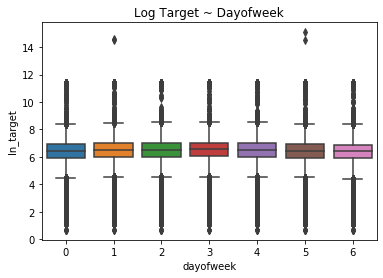

In [74]:
sns.boxplot(x = train['dayofweek'],
            y = train['ln_target'])

plt.title('Log Target ~ Dayofweek')

* 시간과 요일별 target의 분포의 차이는 눈에 띌 정도로 보이지 않는다.
* 평일과 주말을 나눠서 시간대 별로 살펴 보려한다.

## 주말 변수 생성(주말이면 1 아니면 0)

In [76]:
weekend = pd.DataFrame({'dayofweek' : [0,1,2,3,4,5,6], 'weekend' : [1,0,0,0,0,0,1]})

train = pd.merge(train, weekend, on = 'dayofweek')
test = pd.merge(test, weekend, on = 'dayofweek')

### 주말 타겟 분포 확인

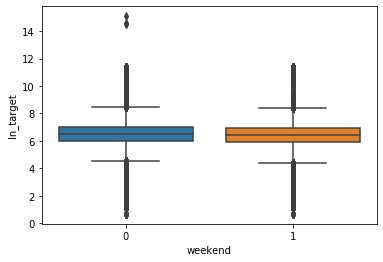

In [80]:
sns.boxplot(x = train['weekend'],
            y = train['ln_target'])

0         AxesSubplot(0.1,0.15;0.363636x0.75)
1    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

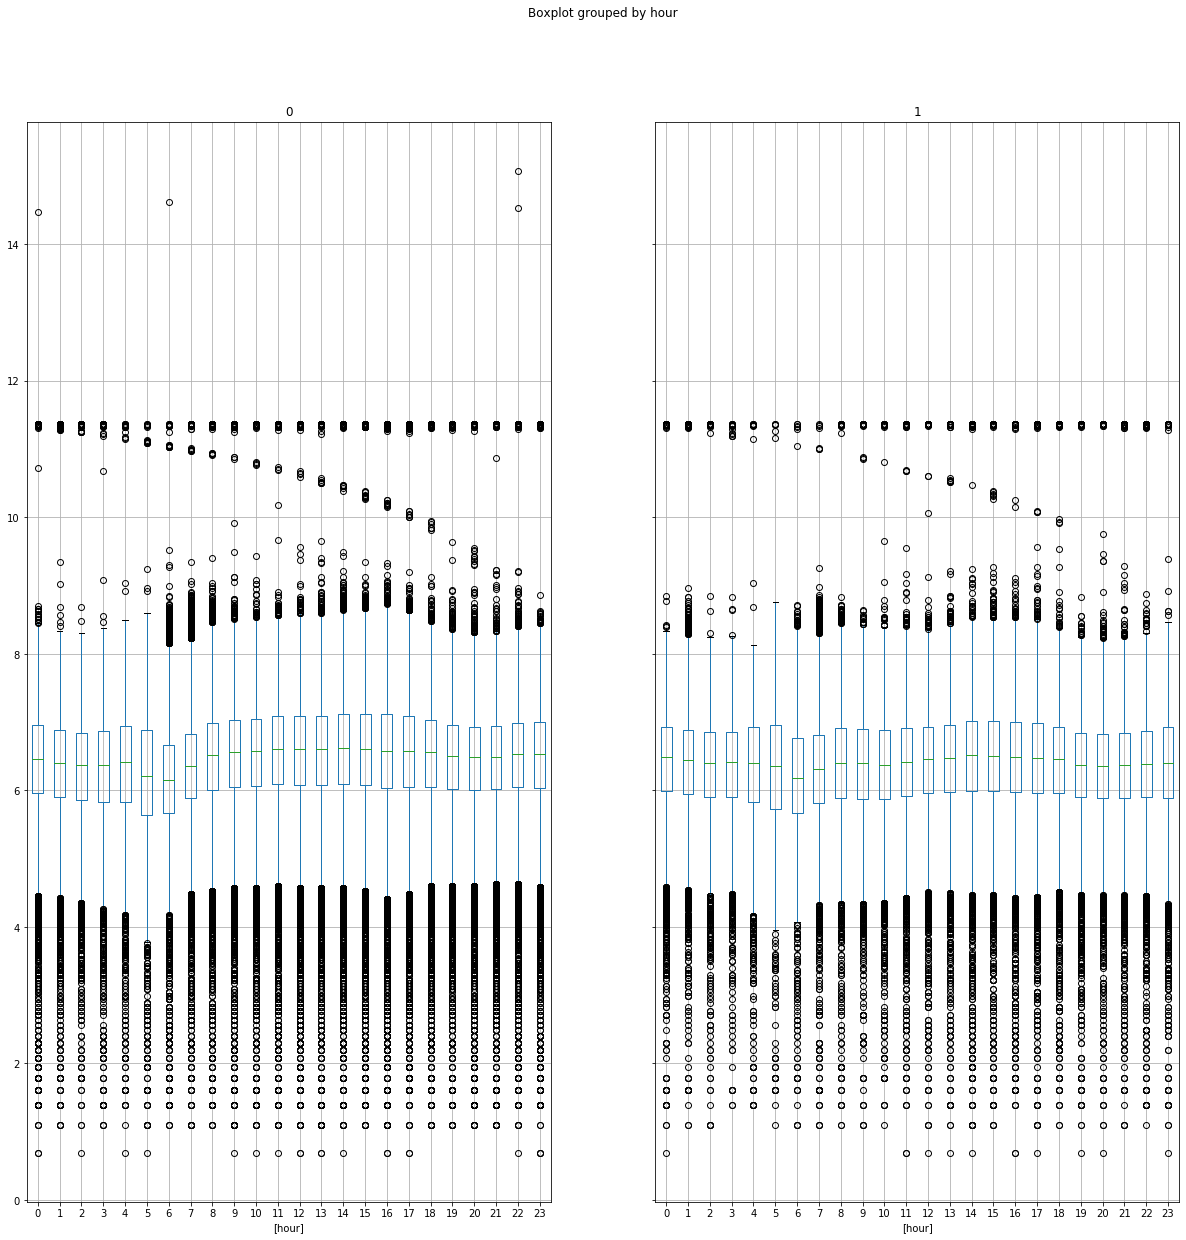

In [81]:
train.groupby(by = 'weekend').boxplot(column = ['ln_target'], by = ['hour'], figsize = (20,20))

## 평일과 주말 비교 결과 별 차이가 없어 보인다